Discovering meaningful patterns in Dungeons and Dragons monster data using various clustering methods


Amazing Data set found [here](https://www.kaggle.com/travistyler/dnd-5e-monster-manual-stats), Thank you [Travis.T](https://www.kaggle.com/travistyler)

Helpful Links:
 - [Towards Data Science article on customer segmentation using clustering](https://towardsdatascience.com/customer-segmentation-using-k-means-clustering-d33964f238c3)
 - [Machine Learning Mastery article providing an overview on various clustering methods](https://machinelearningmastery.com/clustering-algorithms-with-python/)
 - [Towards Data Science article on high dimensional clustering](https://towardsdatascience.com/how-to-cluster-in-high-dimensions-4ef693bacc6)

# TO DO:
# Split up the beginner segment

In [1]:
## math/data packages
import numpy as np
import pandas as pd
from fractions import Fraction

## Visulization packages
import matplotlib.pyplot as plt
import seaborn as sns

## Statistic Packages
import scipy

### Here is a quick overview of the data

Each row contains the name of the Monster, as well as basic attributes like size, type, and alighnment (good vs evil and lawful vs chaotic). After than it has over 35 numerical columns. 6 key columns are the fundamental attributes: strength, dexterity, constituion, intelligence, wisdom, charisma.

Each attribute also has its own column for modifier, which can be defined by the following equation:

modifer = (attribute - 10)/2    <--- always rounded down

an attribute value of 16 has a modifier of 3, an attribute value of 11 has a modifier of 0, an attribute value of 8 has a modifier of -1 and so on

Other notable columns in this dataset are hp (health points), ac (armor class), speed, and attriburtes pertaining to skills like perception, persuasion, or intimidation.

In [2]:
data = pd.read_csv("cleaned_monsters_basic.csv", index_col = "Unnamed: 0")
data.head()

,name,size,monster_type,alignment,ac,hp,strength,str_mod,dex,dex_mod,...,perception,stealth,persuasion,insight,deception,arcana,religion,acrobatics,athletics,intimidation
0,Aboleth,Large,Aberration,lawful evil,17,135,21,5,9,-1,...,10,0,0,0,0,0,0,0,0,0
1,Acolyte,Medium,Humanoid (any race),any alignment,10,9,10,0,10,0,...,0,0,0,0,0,0,0,0,0,0
2,Adult Black Dragon,Huge,Dragon,chaotic evil,19,195,23,6,14,2,...,11,7,0,0,0,0,0,0,0,0
3,Adult Blue Dragon,Huge,Dragon,lawful evil,19,225,25,7,10,0,...,12,5,0,0,0,0,0,0,0,0
4,Adult Brass Dragon,Huge,Dragon,chaotic good,18,172,23,6,10,0,...,11,5,8,0,0,0,0,0,0,0


## Data Preprocessing

Out of our 44 total columns, we only have 2 columns that have null values (senses and languages)

In [3]:
## Lets change the cr from a variable to a float
data['cr'] = data['cr'].apply(lambda x: float(Fraction(x)))

## and look for nulls
nulls_by_col = data.isnull().sum(axis=0)
nulls_by_col.name = 'nulls'

col_w_nulls = nulls_by_col[nulls_by_col != 0]
col_w_nulls

senses        57
languages    128
Name: nulls, dtype: int64

In [4]:
data[["name", "monster_type","senses", "languages"]][95:100]

,name,monster_type,senses,languages
95,Efreeti,Elemental,"Darkvision 120 Ft., passive Perception 12",Ignan
96,Elephant,Beast,NaN,NaN
97,Elk,Beast,NaN,NaN
98,Erinyes,Fiend (devil),"Truesight 120 Ft., passive Perception 12","Infernal, Telepathy 120 Ft."
99,Ettercap,Monstrosity,"Darkvision 60 Ft., passive Perception 13",NaN


It looks like there are some monsters that have no special senses or speak any languages. This is not a data entry, some monsters like elephants do not speak any language

We solve this problem by filling the null values with custom variables

In [5]:
data["languages"].fillna("noLanguages", inplace=True)
data["senses"].fillna("noSenses", inplace=True)

data[["name", "monster_type","senses", "languages"]][95:100]

,name,monster_type,senses,languages
95,Efreeti,Elemental,"Darkvision 120 Ft., passive Perception 12",Ignan
96,Elephant,Beast,noSenses,noLanguages
97,Elk,Beast,noSenses,noLanguages
98,Erinyes,Fiend (devil),"Truesight 120 Ft., passive Perception 12","Infernal, Telepathy 120 Ft."
99,Ettercap,Monstrosity,"Darkvision 60 Ft., passive Perception 13",noLanguages


## Feature Creation

Since high level monsters can be higher in every attribute than lower level monsters, we will premtively create bins in our data for cr (challenge rating, the "level" of a monster). 

In [6]:
conditions = [
    (data['cr'] <= 6),
    (data['cr'] > 6) & (data['cr'] <= 12),
    (data['cr'] > 12)
    ]

# create a list of the values we want to assign for each condition
values = ['beginner', 'intermediate', 'advanced']

# create a new column and use np.select to assign values to it using our lists as arguments
data['cr_bin'] = np.select(conditions, values)

# display updated DataFrame
data.head()

,name,size,monster_type,alignment,ac,hp,strength,str_mod,dex,dex_mod,...,stealth,persuasion,insight,deception,arcana,religion,acrobatics,athletics,intimidation,cr_bin
0,Aboleth,Large,Aberration,lawful evil,17,135,21,5,9,-1,...,0,0,0,0,0,0,0,0,0,intermediate
1,Acolyte,Medium,Humanoid (any race),any alignment,10,9,10,0,10,0,...,0,0,0,0,0,0,0,0,0,beginner
2,Adult Black Dragon,Huge,Dragon,chaotic evil,19,195,23,6,14,2,...,7,0,0,0,0,0,0,0,0,advanced
3,Adult Blue Dragon,Huge,Dragon,lawful evil,19,225,25,7,10,0,...,5,0,0,0,0,0,0,0,0,advanced
4,Adult Brass Dragon,Huge,Dragon,chaotic good,18,172,23,6,10,0,...,5,8,0,0,0,0,0,0,0,advanced


## Data Exploration

First, we look at how each of the main attributes interact with cr (challenge rating)

We see that there are some strong correlations between a mosters level and its strength/constitution, a relativly weak correlation between a mosnters level and its intelligence, wisdom, and charisma. Finally, we see that there is virtually no correlation between a monster's level and its charisma.

In [7]:
def get_corr(dat_1, dat_2):
    reg_model = scipy.stats.linregress(x = dat_1, y = dat_2)
    return(reg_model.rvalue)

print("Correlatiion between level and strength: ", round(get_corr(data.cr, data.strength), 3))
print("Correlatiion between level and intelligence: ", round(get_corr(data.cr, data.intel), 3))
print("Correlatiion between level and dexterity: ", round(get_corr(data.cr, data.dex), 3))
print("Correlatiion between level and constitution (toughness): ", round(get_corr(data.cr, data.con), 3))
print("Correlatiion between level and wisdom: ", round(get_corr(data.cr, data.wis), 3))
print("Correlatiion between level and charisma: ", round(get_corr(data.cr, data.cha), 3))

Correlatiion between level and strength:  0.721
Correlatiion between level and intelligence:  0.635
Correlatiion between level and dexterity:  -0.023
Correlatiion between level and constitution (toughness):  0.86
Correlatiion between level and wisdom:  0.548
Correlatiion between level and charisma:  0.68


<AxesSubplot:xlabel='cr', ylabel='cha'>

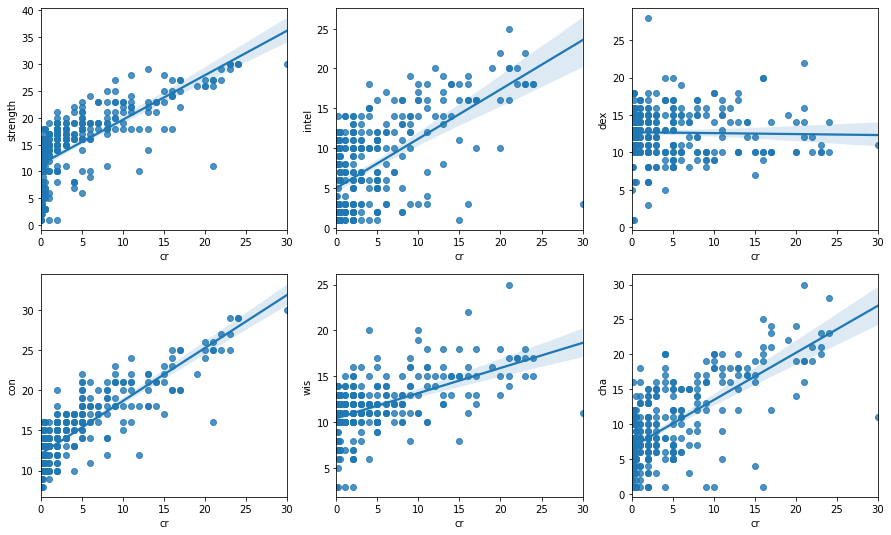

In [8]:
fig, axes = plt.subplots(2, 3,figsize=(15,9))
sns.regplot(x="cr",y = "strength" ,data = data, ax=axes[0,0])
sns.regplot(x="cr",y = "intel" ,data = data, ax=axes[0,1])
sns.regplot(x="cr",y = "dex" ,data = data, ax=axes[0,2])
sns.regplot(x="cr",y = "con" ,data = data, ax=axes[1,0])
sns.regplot(x="cr",y = "wis" ,data = data, ax=axes[1,1])
sns.regplot(x="cr",y = "cha" ,data = data, ax=axes[1,2])

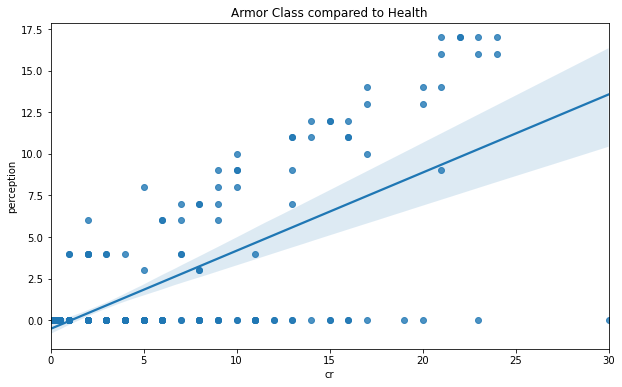

In [9]:
plt.figure(figsize=(10,6))
plt.title("Armor Class compared to Health")
sns.axes_style("dark")
sns.regplot(x="cr",y = "perception" ,data = data)
plt.show()

In [10]:
data.columns

Index(['name', 'size', 'monster_type', 'alignment', 'ac', 'hp', 'strength',
       'str_mod', 'dex', 'dex_mod', 'con', 'con_mod', 'intel', 'int_mod',
       'wis', 'wis_mod', 'cha', 'cha_mod', 'senses', 'languages', 'cr',
       'str_save', 'dex_save', 'con_save', 'int_save', 'wis_save', 'cha_save',
       'speed', 'swim', 'fly', 'climb', 'burrow', 'number_legendary_actions',
       'history', 'perception', 'stealth', 'persuasion', 'insight',
       'deception', 'arcana', 'religion', 'acrobatics', 'athletics',
       'intimidation', 'cr_bin'],
      dtype='object')

In [11]:
data.monster_type.unique()

array(['Aberration', 'Humanoid (any race)', 'Dragon', 'Elemental',
       'Monstrosity', 'Construct', 'Beast', 'Plant', 'Fiend (demon)',
       'Fiend (devil)', 'Ooze', 'Fey', 'Humanoid (goblinoid)', 'Giant',
       'Celestial', 'Humanoid (gnome)', 'Monstrosity (shapechanger)',
       'Humanoid (elf)', 'Humanoid (dwarf)', 'Undead', 'Humanoid (gnoll)',
       'Humanoid (grimlock)', 'Humanoid (human)', 'Fiend', 'Fiend (devil',
       'Fiend (shapechanger)', 'Humanoid (kobold)', 'Monstrosity (titan)',
       'Humanoid (lizardfolk)', 'Humanoid (merfolk)', 'Humanoid (orc)',
       'Humanoid (sahuagin)', 'Swarm of tiny beasts',
       'Undead (shapechanger)', 'Humanoid (human'], dtype=object)

## The Modeling

In [12]:
features_1 = ["strength", 'dex', 'con', 'intel', 'wis', 'cha']

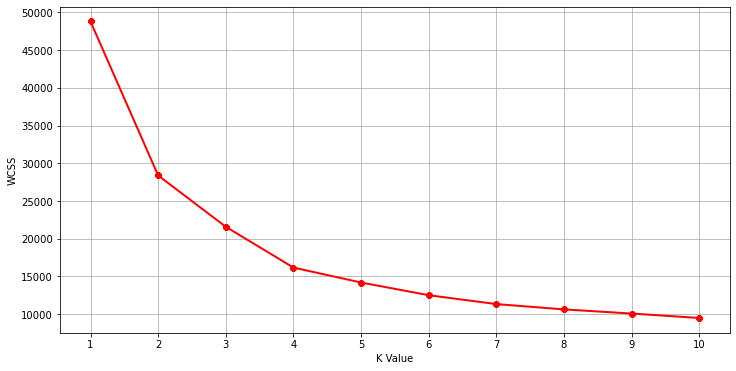

In [13]:
## We set up a kmeans-based scree plot to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(data[features_1])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

^ Based on the above scree plot, we see that 4 clusters are optimal

In [14]:
## We create our 4 k means clusters and add it to our data
km = KMeans(n_clusters=4)
clusters = km.fit_predict(data[features_1])
data["label_features_km_4"] = clusters

<AxesSubplot:xlabel='cr', ylabel='cha'>

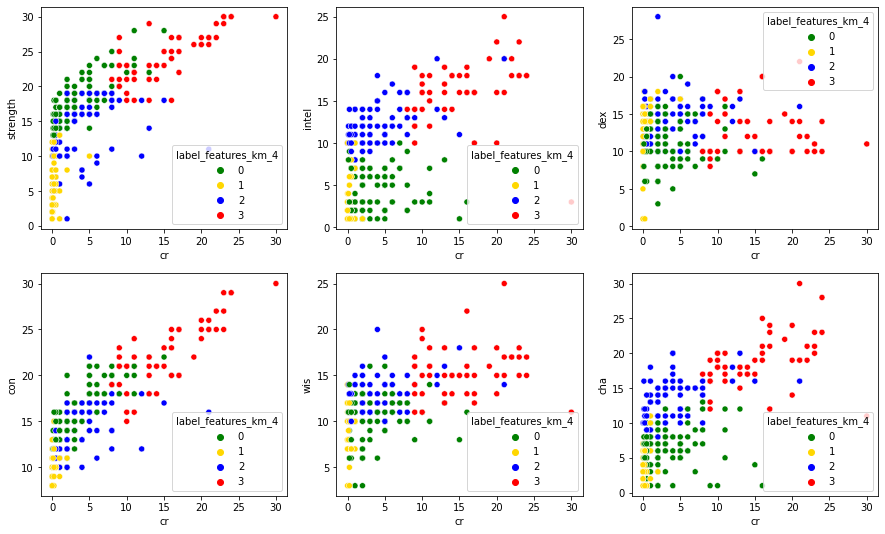

In [15]:
## Then we create a scatter plot for each of the attributes and assign the color of each point based off of its cluster.
fig, axes = plt.subplots(2, 3,figsize=(15,9))
km_4_palette = ['green','gold','blue','red']

sns.scatterplot(x="cr", y = "strength", hue = "label_features_km_4", palette= km_4_palette, data = data, ax=axes[0,0])
sns.scatterplot(x="cr", y = "intel", hue = "label_features_km_4", palette= km_4_palette, data = data, ax=axes[0,1])
sns.scatterplot(x="cr", y = "dex", hue = "label_features_km_4", palette= km_4_palette, data = data, ax=axes[0,2])
sns.scatterplot(x="cr", y = "con", hue = "label_features_km_4", palette= km_4_palette, data = data, ax=axes[1,0])
sns.scatterplot(x="cr", y = "wis", hue = "label_features_km_4", palette= km_4_palette, data = data, ax=axes[1,1])
sns.scatterplot(x="cr", y = "cha", hue = "label_features_km_4", palette= km_4_palette, data = data, ax=axes[1,2])

### Takeaway: It looks like there is a large cluster for monsters that have high numbers for every stat

This is a nice discovery, but it was also very expected and does not show us too much about the nature of the data.

We see that:
 - The blue has high stats for every charecteristic and also tends to have a higher cr. This makes sense since cr and statistic attributes tend to be positivly correlated.
 - One green cluster tends to be lower in all charecteristics and cr
 - The yellow cluster tends to be higher in stregth and consitution than the red cluster
 - the red cluster tends to be higher in intelligence, dexterity, wisdom, and charisma than than yellow while spanning a similar cr range
 - both yellow and red custers span a higher cr range than the green cluster and lower than the blue cluster

## lets segment our data into 3 different cr bins: Beginner, intermediate, and advanced

This will help mitigate some of the influence that CR has on character attribute.

In [16]:
data.cr_bin.unique()

array(['intermediate', 'beginner', 'advanced'], dtype=object)

In [17]:
beginner_monsters = data[data.cr_bin == "beginner"]
beginner_monsters.shape

(247, 46)

In [18]:
intermediate_monsters = data[data.cr_bin == "intermediate"]
intermediate_monsters.shape

(39, 46)

In [19]:
advanced_monsters = data[data.cr_bin == "advanced"]
advanced_monsters.shape

(38, 46)

## Now we repeat the clustering process with each bin


### Beginner

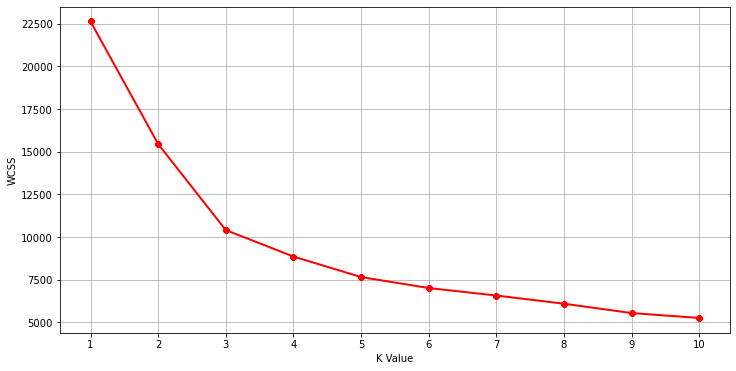

In [20]:
from sklearn.cluster import KMeans
wcss_beginner = []
for k in range(1,11):
    kmeans_beginner = KMeans(n_clusters=k, init="k-means++")
    kmeans_beginner.fit(beginner_monsters[features_1])
    wcss_beginner.append(kmeans_beginner.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss_beginner, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [21]:
km_beginner = KMeans(n_clusters=3)
clusters_beginner = km_beginner.fit_predict(beginner_monsters[features_1])
beginner_monsters["clusters_km_3"] = clusters_beginner

<ipython-input-21-ff179e99dc71>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beginner_monsters["clusters_km_3"] = clusters_beginner


<AxesSubplot:xlabel='cr', ylabel='cha'>

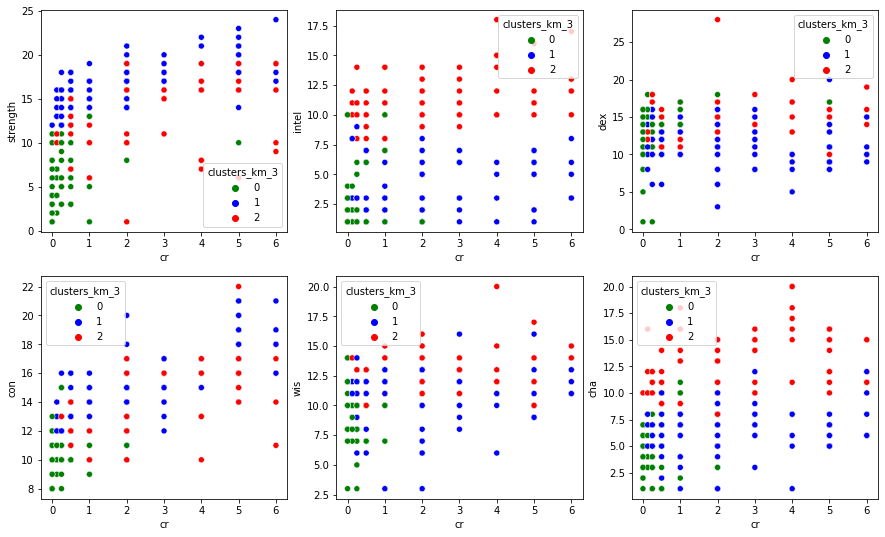

In [22]:
fig, axes = plt.subplots(2, 3,figsize=(15,9))
km_3_palette = ['green','blue','red']

sns.scatterplot(x="cr", y = "strength", hue = "clusters_km_3", palette= km_3_palette, data = beginner_monsters, ax=axes[0,0])
sns.scatterplot(x="cr", y = "intel", hue = "clusters_km_3", palette= km_3_palette, data = beginner_monsters, ax=axes[0,1])
sns.scatterplot(x="cr", y = "dex", hue = "clusters_km_3", palette= km_3_palette, data = beginner_monsters, ax=axes[0,2])
sns.scatterplot(x="cr", y = "con", hue = "clusters_km_3", palette= km_3_palette, data = beginner_monsters, ax=axes[1,0])
sns.scatterplot(x="cr", y = "wis", hue = "clusters_km_3", palette= km_3_palette, data = beginner_monsters, ax=axes[1,1])
sns.scatterplot(x="cr", y = "cha", hue = "clusters_km_3", palette= km_3_palette, data = beginner_monsters, ax=axes[1,2])

## Conclusion

We see that there is no stark seperation in the data (it really makes a person miss the simplified examples from their intro to machine learning class). While there is no major seperation, there are some notable differences in the data.

The red cluster tends to be much lower in every attribute except for dexterity. The red cluster also tends to be lower in cr, which explains the low attribute scores since cr is correrlated with all atrributes except for dexterity.

The green cluster tends to be higher in strength and constitution than the remanining clusters while being lower in intelligence, dexterity, wisdom, and charisma.

The blue clusteer tends to be the opposite of the green cluster. It tends to be higher in intelligence, dexterity, wisdom, and charisma while being lower in strength and constituion


The fact that the red cluster is overwhelmingly low on the CR level suggests that it might be worth splitting the "begginer" monsters into two of their own bins

## Warning!!! There are less samples available then reccomended given the scope of this clustering

In [Required Sample Sizes for Data-Driven Market Segmentation Analyses in Tourism](https://www.researchgate.net/publication/270710943_Required_Sample_Sizes_for_Data-Driven_Market_Segmentation_Analyses_in_Tourism), written by Sara Dolnicar, Bettina Grün, Friedrich Leisch, and Kathrin Schmidt, they state that you want at minimum 2^^d data samples, where d is the number of dimensions

In this case, we have 39 intermediate monster samples and 38 advanced monster samples when we need at least 64 according to the article (though the authors reccomend 5 * 2^^d). The issue is that there are 6 core stats in Dungeons and Dragons, and arbitrarily leaving out a random character will bias the data.

### Intermediate

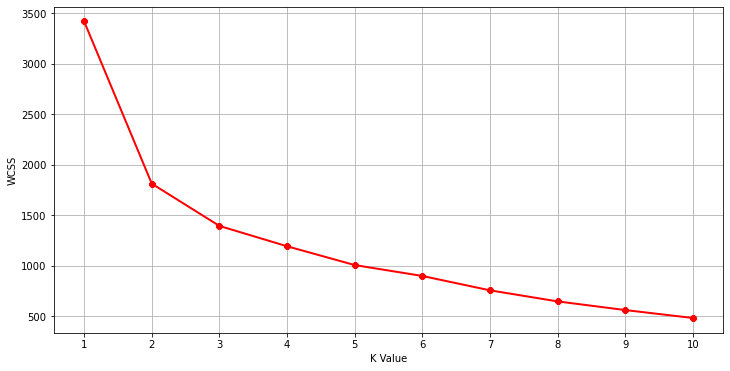

In [23]:
from sklearn.cluster import KMeans
wcss_intermediate = []
for k in range(1,11):
    kmeans_intermediate = KMeans(n_clusters=k, init="k-means++")
    kmeans_intermediate.fit(intermediate_monsters[["strength", 'dex', 'con', 'intel', 'wis', 'cha']])

    wcss_intermediate.append(kmeans_intermediate.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss_intermediate, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [24]:
km_intermediate = KMeans(n_clusters=3)
clusters_intermediate = km_intermediate.fit_predict(intermediate_monsters[features_1])
intermediate_monsters["clusters_km_3"] = clusters_intermediate

<ipython-input-24-d3992adc9e6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intermediate_monsters["clusters_km_3"] = clusters_intermediate


<AxesSubplot:xlabel='cr', ylabel='cha'>

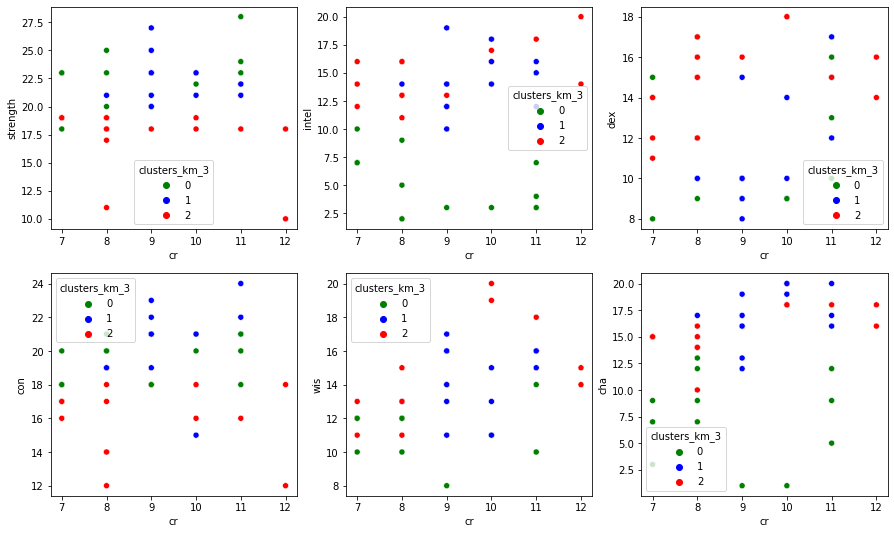

In [25]:
fig, axes = plt.subplots(2, 3,figsize=(15,9))
km_3_palette = ['green','blue','red']

sns.scatterplot(x="cr", y = "strength", hue = "clusters_km_3", palette= km_3_palette, data = intermediate_monsters, ax=axes[0,0])
sns.scatterplot(x="cr", y = "intel", hue = "clusters_km_3", palette= km_3_palette, data = intermediate_monsters, ax=axes[0,1])
sns.scatterplot(x="cr", y = "dex", hue = "clusters_km_3", palette= km_3_palette, data = intermediate_monsters, ax=axes[0,2])
sns.scatterplot(x="cr", y = "con", hue = "clusters_km_3", palette= km_3_palette, data = intermediate_monsters, ax=axes[1,0])
sns.scatterplot(x="cr", y = "wis", hue = "clusters_km_3", palette= km_3_palette, data = intermediate_monsters, ax=axes[1,1])
sns.scatterplot(x="cr", y = "cha", hue = "clusters_km_3", palette= km_3_palette, data = intermediate_monsters, ax=axes[1,2])

## Conclusion

While there are some slight patterns in the scatterplots, there is very little sepreation between the clusters. Overall, more data is needed to meet the criteria of the clustering.

The blue cluster tends to be higher in intelligence, wisdom, charisma, and dexterity than the other clusters and lowest in strength and constituion

The green cluster tends to be similarly high in strenght and constituion as the red cluster, and tends to be lower in intelligence, wisdom, and charisma.

The red cluster behaves similarly as the green cluster, but tends to be higher in constitution than the blue cluster and charisma than the other clusters.

### Advanced

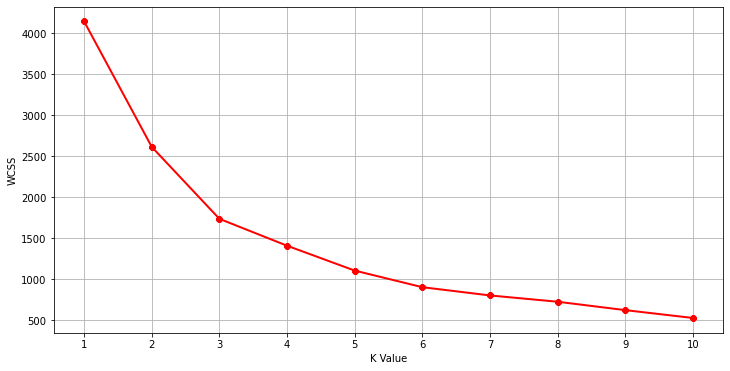

In [26]:
from sklearn.cluster import KMeans
wcss_advanced = []
for k in range(1,11):
    kmeans_advanced = KMeans(n_clusters=k, init="k-means++")
    kmeans_advanced.fit(advanced_monsters[features_1])
    wcss_advanced.append(kmeans_advanced.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss_advanced, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [27]:
km_advanced = KMeans(n_clusters=3)
clusters_advanced = km_advanced.fit_predict(advanced_monsters[features_1])
advanced_monsters["clusters_km_3"] = clusters_advanced

<ipython-input-27-55b09946c401>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  advanced_monsters["clusters_km_3"] = clusters_advanced


<AxesSubplot:xlabel='cr', ylabel='cha'>

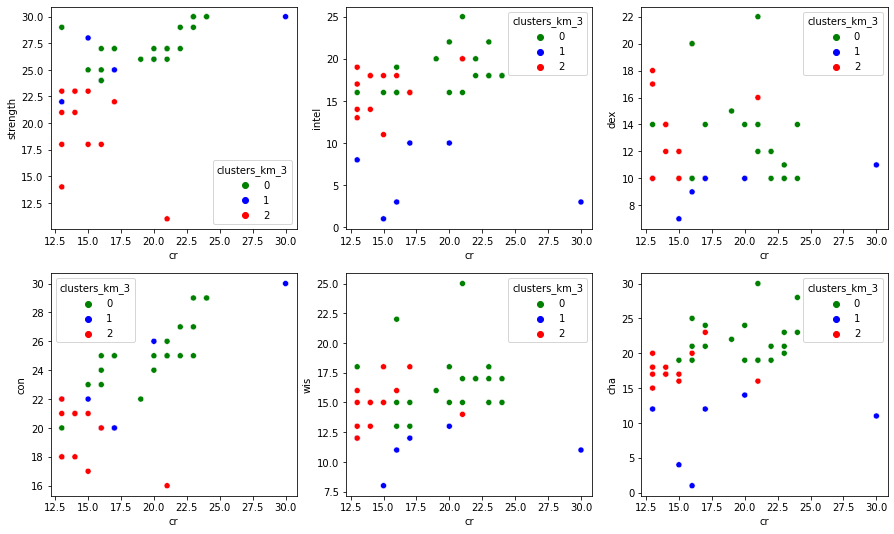

In [28]:
fig, axes = plt.subplots(2, 3,figsize=(15,9))

km_2_palette = ["blue", "red"]
km_3_palette = ['green','blue','red']
km_4_palette = ['green','gold','blue','red']

sns.scatterplot(x="cr", y = "strength", hue = "clusters_km_3", palette= km_3_palette, data = advanced_monsters, ax=axes[0,0])
sns.scatterplot(x="cr", y = "intel", hue = "clusters_km_3", palette= km_3_palette, data = advanced_monsters, ax=axes[0,1])
sns.scatterplot(x="cr", y = "dex", hue = "clusters_km_3", palette= km_3_palette, data = advanced_monsters, ax=axes[0,2])
sns.scatterplot(x="cr", y = "con", hue = "clusters_km_3", palette= km_3_palette, data = advanced_monsters, ax=axes[1,0])
sns.scatterplot(x="cr", y = "wis", hue = "clusters_km_3", palette= km_3_palette, data = advanced_monsters, ax=axes[1,1])
sns.scatterplot(x="cr", y = "cha", hue = "clusters_km_3", palette= km_3_palette, data = advanced_monsters, ax=axes[1,2])

## Conclusion

Just like the intermediate monster clustering, there are no clear seperations in the data accross the 6 attributes. However we see general differences throughout the various clusters.

The green cluster tends to be higher in every attribute except for dexterity. The green cluster also tends to have observations with higher cr values. This makes the higher attributes understandable since cr is correlated with every attribute except for dexterity.

The red cluster tends to be higher in intelligence, dexterity, wisdom, and charisma than the blue cluster while being lower in strength and constitution.

The blue cluster is the opposite of the red cluster. It is higher in strenght and constitution while being lower in intelligence, dexterity, wisdom, and charisma.

## Clustering Part 2 --  Hierarchical Clustering



#### Euclidian + Ward

First we look at a dendogram

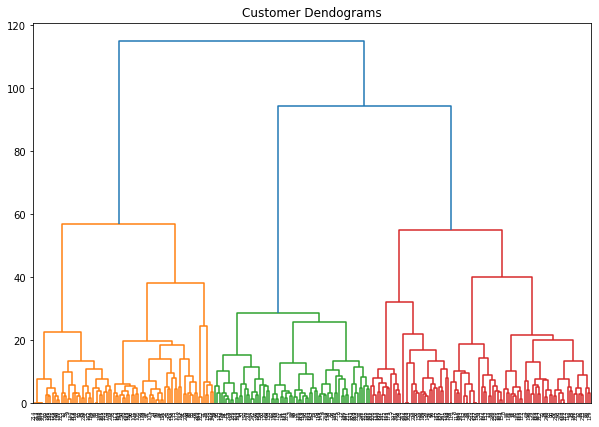

In [29]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(beginner_monsters[features_1], method = "ward"))

In [30]:
from sklearn.cluster import AgglomerativeClustering

cluster_hierarchical = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clusters_h_advanced = cluster_hierarchical.fit_predict(advanced_monsters[features_1])

advanced_monsters["clusters_h_3"] = clusters_h_advanced

<ipython-input-30-d1e116f4f687>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  advanced_monsters["clusters_h_3"] = clusters_h_advanced


<AxesSubplot:xlabel='cr', ylabel='cha'>

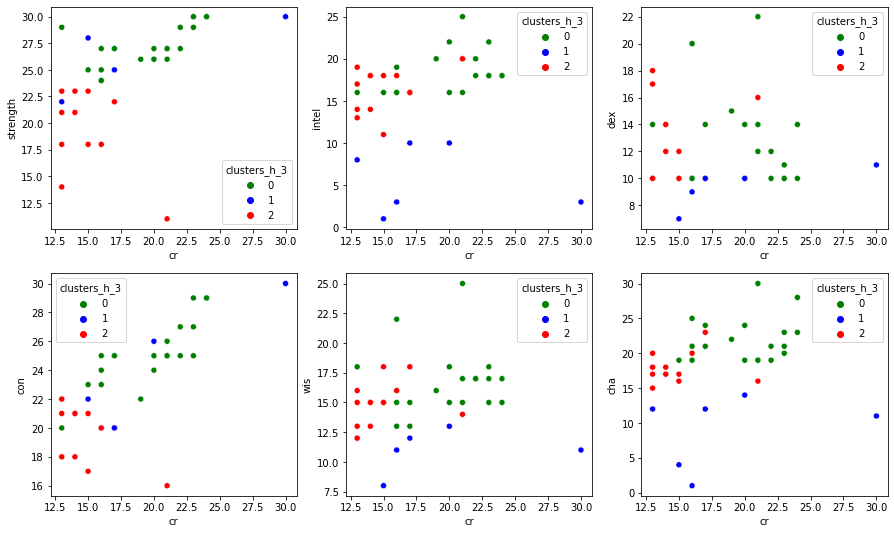

In [31]:
fig, axes = plt.subplots(2, 3,figsize=(15,9))
km_3_palette = ['green','blue','red']

sns.scatterplot(x="cr", y = "strength", hue = "clusters_h_3", palette= km_3_palette, data = advanced_monsters, ax=axes[0,0])
sns.scatterplot(x="cr", y = "intel", hue = "clusters_h_3", palette= km_3_palette, data = advanced_monsters, ax=axes[0,1])
sns.scatterplot(x="cr", y = "dex", hue = "clusters_h_3", palette= km_3_palette, data = advanced_monsters, ax=axes[0,2])
sns.scatterplot(x="cr", y = "con", hue = "clusters_h_3", palette= km_3_palette, data = advanced_monsters, ax=axes[1,0])
sns.scatterplot(x="cr", y = "wis", hue = "clusters_h_3", palette= km_3_palette, data = advanced_monsters, ax=axes[1,1])
sns.scatterplot(x="cr", y = "cha", hue = "clusters_h_3", palette= km_3_palette, data = advanced_monsters, ax=axes[1,2])


#### Average Linkage does not appear to cluster effectivly. The result is that one group is massive and the remainind clusters are very small

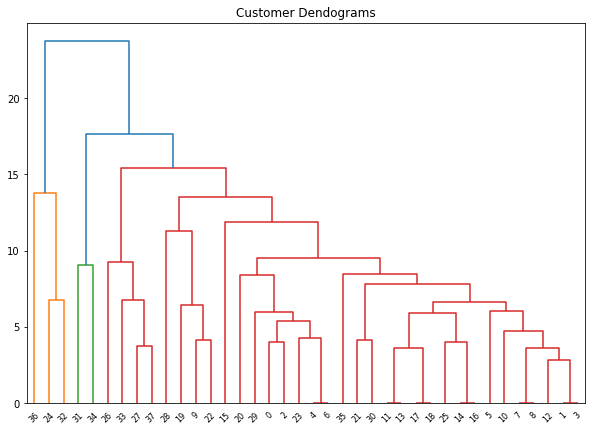

In [32]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(advanced_monsters[features_1], method = "average"))

### Complete does not seem to generate meaningful clusters either

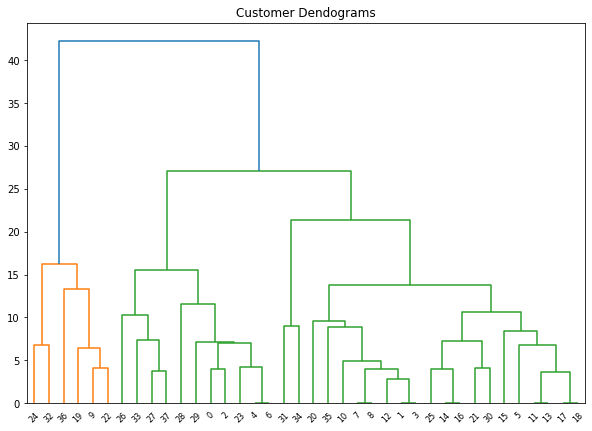

In [33]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(advanced_monsters[features_1], method = "complete"))

In [34]:
from sklearn.cluster import AgglomerativeClustering

cluster_hierarchical = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clusters_h_beginner = cluster_hierarchical.fit_predict(beginner_monsters[features_1])

beginner_monsters["clusters_h_3"] = clusters_h_beginner

<ipython-input-34-a0ca60784c5c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beginner_monsters["clusters_h_3"] = clusters_h_beginner


## Comparing Hierarchical Clustering to KNN

<AxesSubplot:xlabel='cr', ylabel='cha'>

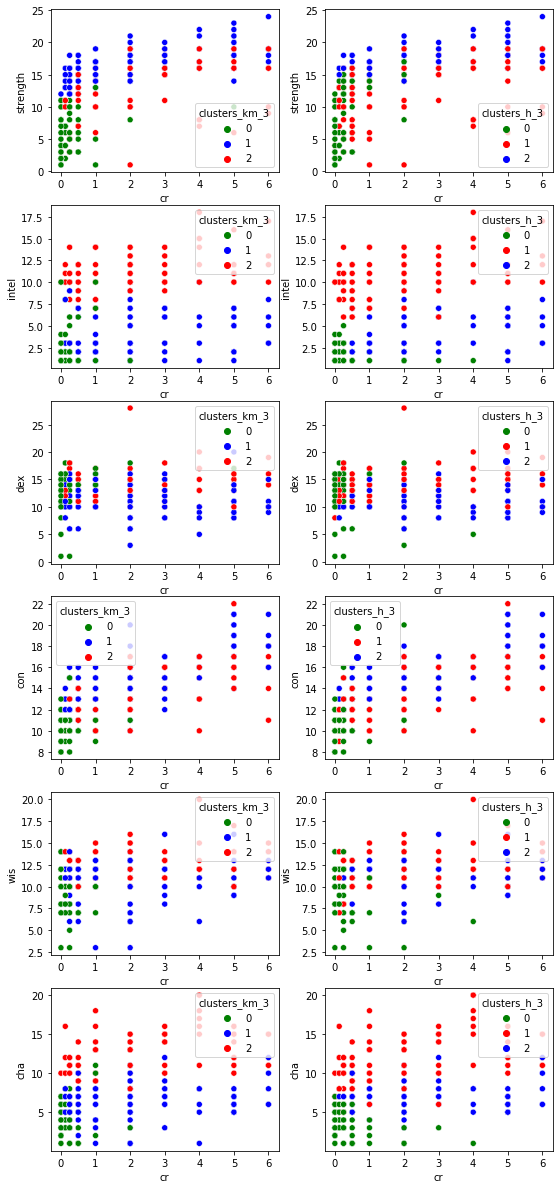

In [36]:
fig, axes = plt.subplots(6, 2,figsize=(9,21))

km_3_palette = ['green','blue','red']
km_3_palette_adj = ['green','red','blue']


## We chart the k means clusters on the left
sns.scatterplot(x="cr", y = "strength", hue = "clusters_km_3", palette= km_3_palette, data = beginner_monsters, ax=axes[0,0])
sns.scatterplot(x="cr", y = "intel", hue = "clusters_km_3", palette= km_3_palette, data = beginner_monsters, ax=axes[1,0])
sns.scatterplot(x="cr", y = "dex", hue = "clusters_km_3", palette= km_3_palette, data = beginner_monsters, ax=axes[2,0])
sns.scatterplot(x="cr", y = "con", hue = "clusters_km_3", palette= km_3_palette, data = beginner_monsters, ax=axes[3,0])
sns.scatterplot(x="cr", y = "wis", hue = "clusters_km_3", palette= km_3_palette, data = beginner_monsters, ax=axes[4,0])
sns.scatterplot(x="cr", y = "cha", hue = "clusters_km_3", palette= km_3_palette, data = beginner_monsters, ax=axes[5,0])

## And the hierarchical clusters on the right
sns.scatterplot(x="cr", y = "strength", hue = "clusters_h_3", palette= km_3_palette_adj, data = beginner_monsters, ax=axes[0,1])
sns.scatterplot(x="cr", y = "intel", hue = "clusters_h_3", palette= km_3_palette_adj, data = beginner_monsters, ax=axes[1,1])
sns.scatterplot(x="cr", y = "dex", hue = "clusters_h_3", palette= km_3_palette_adj, data = beginner_monsters, ax=axes[2,1])
sns.scatterplot(x="cr", y = "con", hue = "clusters_h_3", palette= km_3_palette_adj, data = beginner_monsters, ax=axes[3,1])
sns.scatterplot(x="cr", y = "wis", hue = "clusters_h_3", palette= km_3_palette_adj, data = beginner_monsters, ax=axes[4,1])
sns.scatterplot(x="cr", y = "cha", hue = "clusters_h_3", palette= km_3_palette_adj, data = beginner_monsters, ax=axes[5,1])


## Conclusion

While neither clusteing method produces "clean" results, we can see very slight improvements in the hierarchical clustering in terms of making clusters with meaningful differences in attribute values. These improvements are not universal, as some attributes like wisdom are even more mixed together in hierarchical clustering than centroid-based kmm clustering.

Overall, there